# Olist E-commerce — Sales Performance EDA

## Goal
Understand sales performance over time and across categories/regions, and extract actionable insights for a business stakeholder.

## What you’ll find here
- Data quality checks (missing values, duplicates, outliers, date parsing)
- Core metrics (Orders, GMV proxy, AOV proxy)
- Segmentation by time, category, and customer region
- Key insights and recommendations

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("../../data/raw/olist")
DATA_DIR

PosixPath('../../data/raw/olist')

In [25]:
orders = pd.read_csv(DATA_DIR / "olist_orders_dataset.csv")
items  = pd.read_csv(DATA_DIR / "olist_order_items_dataset.csv")

orders.shape, items.shape

((99441, 8), (112650, 7))

In [26]:
orders.head(), orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


(                           order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp    order_approved_at  \
 0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-07-26 14:31:00 

In [27]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders[date_cols].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [28]:
orders["order_status"].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [29]:
orders_delivered = orders[orders["order_status"] == "delivered"].copy()
orders_delivered.shape

(96478, 8)

In [30]:
orders_items = (
    orders_delivered
    .merge(items, on="order_id", how="left")
)

orders_items.shape

(110197, 14)

In [31]:
orders_items.isna().sum().sort_values(ascending=False).head(10)

order_approved_at                15
order_delivered_customer_date     8
order_delivered_carrier_date      2
order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_estimated_delivery_date     0
order_item_id                     0
product_id                        0
dtype: int64

In [32]:
orders_items["item_revenue"] = orders_items["price"]
orders_items["item_freight"] = orders_items["freight_value"]
orders_items["item_gmv"] = orders_items["item_revenue"] + orders_items["item_freight"]

orders_items[["item_revenue", "item_freight", "item_gmv"]].describe()

,item_revenue,item_freight,item_gmv
count,110197.000000,110197.000000,110197.000000
mean,119.980563,19.948598,139.929161
std,182.299446,15.698136,189.319151
min,0.850000,0.000000,6.080000
25%,39.900000,13.080000,55.180000
50%,74.900000,16.260000,92.130000
75%,134.170000,21.150000,157.510000
max,6735.000000,409.680000,6929.310000


In [33]:
orders_agg = (
    orders_items
    .groupby("order_id", as_index=False)
    .agg(
        order_gmv=("item_gmv", "sum"),
        order_items=("order_item_id", "count")
    )
)

orders_agg.describe()

,order_gmv,order_items
count,96478.000000,96478.000000
mean,159.826839,1.142198
std,218.794219,0.538804
min,9.590000,1.000000
25%,61.850000,1.000000
50%,105.280000,1.000000
75%,176.260000,1.000000
max,13664.080000,21.000000


In [34]:
orders_time = (
    orders_delivered[["order_id", "order_purchase_timestamp"]]
    .merge(orders_agg, on="order_id", how="left")
)

orders_time["order_month"] = orders_time["order_purchase_timestamp"].dt.to_period("M").astype(str)

orders_time.head()

,order_id,order_purchase_timestamp,order_gmv,order_items,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71,1,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46,1,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12,1,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,72.20,1,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,28.62,1,2018-02


In [35]:
monthly_perf = (
    orders_time
    .groupby("order_month", as_index=False)
    .agg(
        orders=("order_id", "nunique"),
        gmv=("order_gmv", "sum"),
        aov=("order_gmv", "mean")
    )
    .sort_values("order_month")
)

monthly_perf.head(), monthly_perf.tail()

(  order_month  orders        gmv         aov
 0     2016-09       1     143.46  143.460000
 1     2016-10     265   46490.66  175.436453
 2     2016-12       1      19.62   19.620000
 3     2017-01     750  127482.37  169.976493
 4     2017-02    1653  271239.32  164.089123,
    order_month  orders         gmv         aov
 18     2018-04    6798  1132878.93  166.648857
 19     2018-05    6749  1128774.52  167.250633
 20     2018-06    6099  1011978.29  165.925281
 21     2018-07    6159  1027807.28  166.878922
 22     2018-08    6351   985491.64  155.171097)

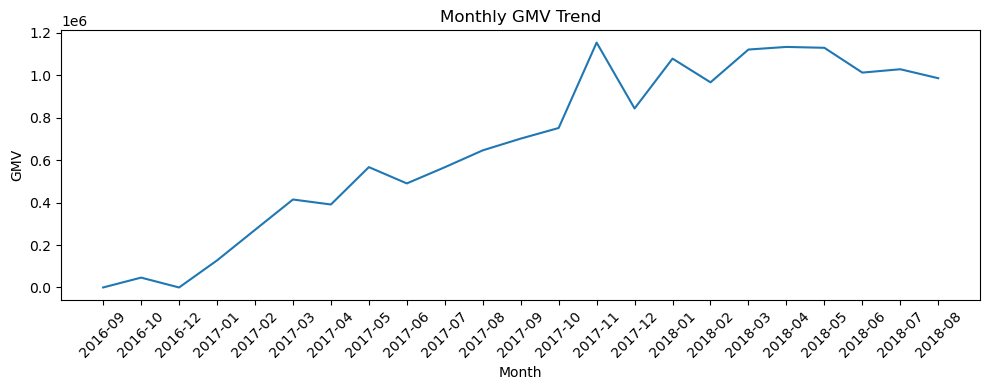

In [36]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_perf["order_month"], monthly_perf["gmv"])
plt.title("Monthly GMV Trend")
plt.xlabel("Month")
plt.ylabel("GMV")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/monthly_gmv_trend.png", dpi=150)
plt.show()

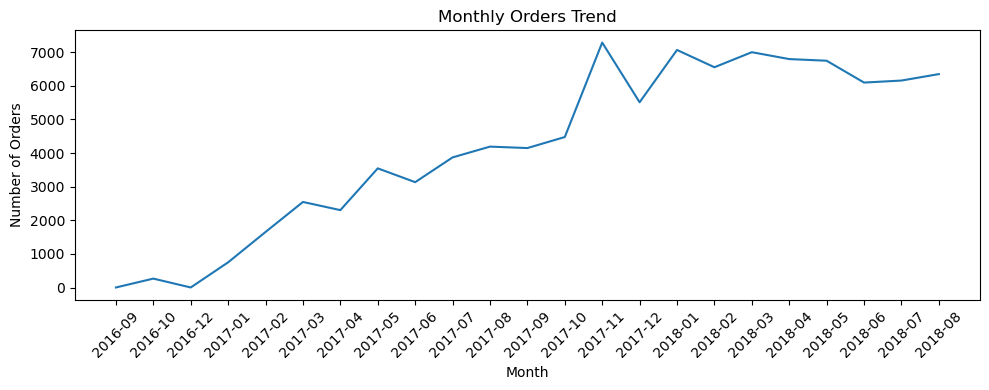

In [37]:
plt.figure(figsize=(10, 4))
plt.plot(monthly_perf["order_month"], monthly_perf["orders"])
plt.title("Monthly Orders Trend")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../reports/monthly_orders_trend.png", dpi=150)
plt.show()

In [38]:
products = pd.read_csv(DATA_DIR / "olist_products_dataset.csv")
categories = pd.read_csv(DATA_DIR / "product_category_name_translation.csv")

products.shape, categories.shape

((32951, 9), (71, 2))

In [39]:
products_en = (
    products
    .merge(
        categories,
        on="product_category_name",
        how="left"
    )
)

products_en[["product_id", "product_category_name", "product_category_name_english"]].head()

,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


In [40]:
orders_items_cat = (
    orders_items
    .merge(
        products_en[["product_id", "product_category_name_english"]],
        on="product_id",
        how="left"
    )
)

orders_items_cat[["product_id", "product_category_name_english"]].head()

,product_id,product_category_name_english
0,87285b34884572647811a353c7ac498a,housewares
1,595fac2a385ac33a80bd5114aec74eb8,perfumery
2,aa4383b373c6aca5d8797843e5594415,auto
3,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop
4,65266b2da20d04dbe00c5c2d3bb7859e,stationery


In [41]:
orders_items_cat["product_category_name_english"].isna().mean()

np.float64(0.014147390582320753)

In [44]:
orders_items_cat["product_category_name_english"] = (
    orders_items_cat["product_category_name_english"]
    .fillna("unknown")
)

In [45]:
orders_items_cat["product_category_name_english"].isna().mean()

np.float64(0.0)

In [42]:
category_perf = (
    orders_items_cat
    .groupby("product_category_name_english", as_index=False)
    .agg(
        gmv=("item_gmv", "sum"),
        items=("order_item_id", "count")
    )
    .sort_values("gmv", ascending=False)
)

category_perf.head(10)

,product_category_name_english,gmv,items
43,health_beauty,1412089.53,9465
70,watches_gifts,1264333.12,5859
7,bed_bath_table,1225209.26,10953
65,sports_leisure,1118256.91,8431
15,computers_accessories,1032723.77,7644
39,furniture_decor,880329.92,8160
49,housewares,758392.25,6795
20,cool_stuff,691680.89,3718
5,auto,669454.75,4140
42,garden_tools,567145.68,4268


In [43]:
plt.figure(figsize=(10, 4))
plt.barh(
    top_categories["product_category_name_english"],
    top_categories["gmv"]
)
plt.gca().invert_yaxis()
plt.title("Top 10 Categories by GMV")
plt.xlabel("GMV")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig("../reports/top_categories_by_gmv.png", dpi=150)
plt.show()

NameError: name 'top_categories' is not defined

<Figure size 1000x400 with 0 Axes>

## Key Insights

1. GMV grew steadily throughout 2017 and stabilized in 2018, driven mainly by order volume rather than AOV.
2. Order volume increased significantly in 2017, indicating strong demand growth.
3. GMV is highly concentrated in a small number of product categories.
4. Health & Beauty and Watches & Gifts are the top revenue-generating categories.
5. Some categories generate high GMV with relatively fewer items, suggesting higher price points.

## Recommendations

- Focus on demand growth levers (acquisition, repeat purchases) rather than pricing.
- Prioritize logistics and availability for top revenue categories.
- Investigate category-level margins to optimize the product mix.